# Handwritten Digits Classifier Project

For this project, our goal is to build a machine learning model that can classify digits written by humans correctly. This is a type of computer vision project, and as such, will be more complex than many of the other project on my portfolio website.

We also will be utilizing neural networks to help us achieve our task. This is mainly due to the fact that image recognition requires us to use a model that is capable of handling millions of features (created from the resolution of images).

### Preprocessing and Preliminary Analysis

In [1]:
# We first import all of our necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [2]:
# We also will load in the digits dataset from scikit-learn
from sklearn.datasets import load_digits

In [3]:
# We then call the laod digits function
data_array = load_digits()

In [4]:
# This structure is a dictionary. As such, we need to check the keys to determine the target
data_array.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
target = pd.Series(data_array['target'])

In [6]:
numbers = pd.DataFrame(data_array['data'])

In [7]:
# We then inspect our dataframe to get an idea of what it looks like
numbers.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


### Visualization

Because we are dealing with handwritten images, it would probably be a good idea to display what these images look like.

In [8]:
first_image = numbers.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

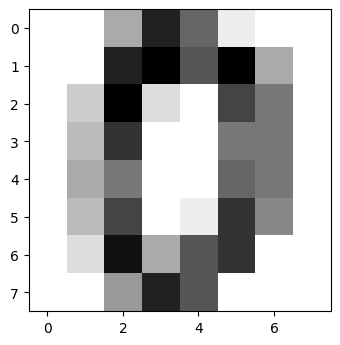

In [9]:
%matplotlib inline
plt.imshow(np_image, cmap='gray_r')

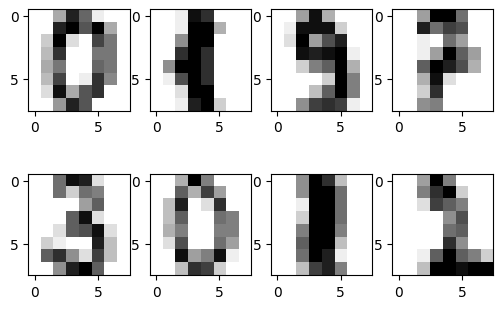

In [10]:
# Let's try creating a subppot to display multiple figures
f, axfig = plt.subplots(2, 4)
axfig[0,0].imshow(numbers.iloc[0].values.reshape(8, 8), cmap='gray_r')
axfig[0,1].imshow(numbers.iloc[99].values.reshape(8, 8), cmap='gray_r')
axfig[0,2].imshow(numbers.iloc[199].values.reshape(8, 8), cmap='gray_r')
axfig[0,3].imshow(numbers.iloc[299].values.reshape(8, 8), cmap='gray_r')

axfig[1,0].imshow(numbers.iloc[999].values.reshape(8, 8), cmap='gray_r')
axfig[1,1].imshow(numbers.iloc[1099].values.reshape(8, 8), cmap='gray_r')
axfig[1,2].imshow(numbers.iloc[1199].values.reshape(8, 8), cmap='gray_r')
axfig[1,3].imshow(numbers.iloc[1299].values.reshape(8, 8), cmap='gray_r')

### K-Nearest Neigbors Model

Before we attempt to implement neural networks, let us first try a simpler K-Nearest Neighbors approach. Recall that the nearest neighbors algorithm compares every unseen observation in the test set to all training observations to loo for similar observations. Resultantly, this model makes no linearity assumptions in the data, which will help us achieve our goal

In [11]:
# We first split our data into training and test sets
index_split = round(.8*len(numbers))
train_features = numbers.iloc[:index_split]
test_features = numbers.iloc[index_split:]
train_target = target.iloc[:index_split]
test_target = target.iloc[index_split:]

In [12]:
# We then construct a pipeline to train and test our knn models
# We first begin by creating an function to train.
def train(features, target_column, k_value):
    knc = KNeighborsClassifier(n_neighbors=k_value, algorithm="auto")
    knc.fit(features, target_column)
    return knc

In [13]:
# We then create a function to test our model
def test(features, target_column, model):
    predictions = model.predict(features)  # Predict with model created with the train() function
    accuracy_df = pd.DataFrame()  # Instantiate an empty dataframe
    accuracy_df["predicted"] = predictions  # Create a column with our predicted values
    target_column = target_column.reset_index(drop=True)
    accuracy_df["correct"] = target_column  # Create a column with the correct values
    accuracy_mask = accuracy_df["predicted"] == accuracy_df["correct"]  # Filter correct values
    score = len(accuracy_df[accuracy_mask]) / len(accuracy_df)  # Divide the number correct by the total
    return score

In [14]:
# We also create a cross validation function to better estimate our model
def cross_validate(k_value):
    accuracies = []
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(numbers):
        training_set, test_set = numbers.loc[train_index], numbers.loc[test_index]
        training_labels, test_labels = target.loc[train_index], target.loc[test_index]
        model = train(training_set, training_labels, k_value)
        score = test(test_set, test_labels, model)
        accuracies.append(score)
    return accuracies 

In [15]:
# We now test out our functions above to ensure they work
trial_model = train(train_features, train_target, 1)
test_score = test(test_features, test_target, trial_model)

In [16]:
print("Our accuracy for our trial model is {}".format(test_score))

Our accuracy for our trial model is 0.9554317548746518


Now, let's try our model with cross validation. We first must make a change to our test function before we call the cross validation function.

In [18]:
final_score = np.mean(cross_validate(1))
print("With k-fold cross validation, our model is {} percent accurate".format(round(final_score, 2)))

With k-fold cross validation, our model is 0.97 percent accurate


Text(0.5, 1.0, 'Accuracy versus K-Value')

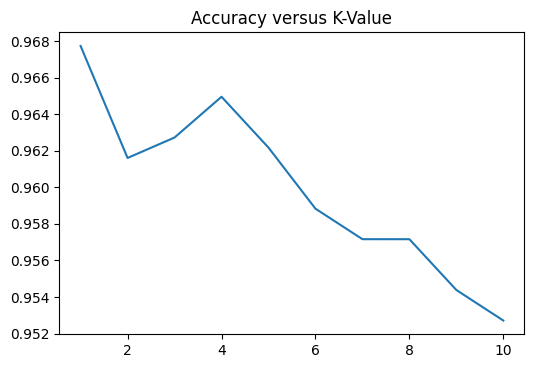

In [23]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracy = []
for k in k_values:
    scores = cross_validate(k)
    final_score = np.mean(scores)
    accuracy.append(final_score)
plt.plot(k_values, accuracy)
plt.title("Accuracy versus K-Value")

### Neural Network

Our K-Nearest Neighbors model was very accurate, however, there are some downsides to this model. For starters, it has high memory usage. Coupled with the fact that there is no model representation to debug and explore, it raises the question of is this a viable model.

To really apply my knowledge of Machine Learning, this type of problem is a prime candidate for a Neural Network classifier. As a result, we will construct a neural network model below to try and predict our handwritten images. 

In [28]:
# We reconstruct the pipeline from above by replacing the K-NN class with a Neural Network class
def train_nn(size, features, target_column):
    nn_clf = MLPClassifier(hidden_layer_sizes=(size,), activation="logistic")
    network = nn_clf.fit(features, target_column)
    return network

def test(features, target_column, model):
    predictions = model.predict(features)  # Predict with model created with the train() function
    accuracy_df = pd.DataFrame()  # Instantiate an empty dataframe
    accuracy_df["predicted"] = predictions  # Create a column with our predicted values
    target_column = target_column.reset_index(drop=True)
    accuracy_df["correct"] = target_column  # Create a column with the correct values
    accuracy_mask = accuracy_df["predicted"] == accuracy_df["correct"]  # Filter correct values
    score = len(accuracy_df[accuracy_mask]) / len(accuracy_df)  # Divide the number correct by the total
    return score

def cross_validate(size):
    accuracies = []
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(numbers):
        training_set, test_set = numbers.loc[train_index], numbers.loc[test_index]
        training_labels, test_labels = target.loc[train_index], target.loc[test_index]
        model = train_nn(size, training_set, training_labels)
        score = test(test_set, test_labels, model)
        accuracies.append(score)
    final_score = (np.mean(accuracies)) * 100
    return final_score 

In [29]:
# We now apply our reconstructed function
neurons = [8, 16, 32, 64, 128, 256]
for n in neurons:
    nn_accuracy = cross_validate(n)
    print("A neural network with {} nuerons is {}% accurate".format(n, nn_accuracy))

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



A neural network with 8 nuerons is 87.42365751051719% accurate


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



A neural network with 16 nuerons is 92.98824548379115% accurate


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



A neural network with 32 nuerons is 94.99158624102945% accurate


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



A neural network with 64 nuerons is 94.7687453600594% accurate
A neural network with 128 nuerons is 95.10269735214055% accurate
A neural network with 256 nuerons is 95.26961148230636% accurate


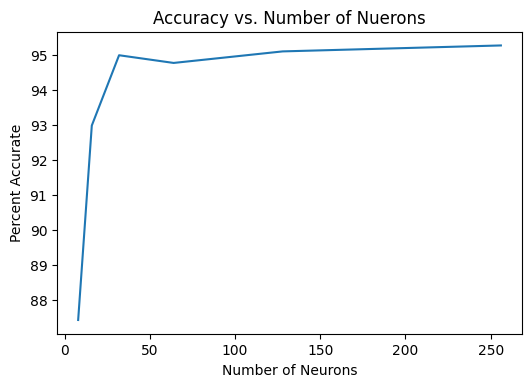

In [30]:
percentiles = [87.42, 92.98, 94.99, 94.77, 95.10, 95.27]
plt.plot(neurons, percentiles)
plt.title("Accuracy vs. Number of Nuerons")
plt.xlabel("Number of Neurons")
plt.ylabel("Percent Accurate")
plt.show()

It appears that, while our model with 256 neurons was over 95% accurate, a neural network model with a single hidden layer does not edge our our K-Nearest Neighbors model in terms of it's performance. As such, we will look to incorporate a second hidden layer in our next iteration of our neural network model.

In [31]:
# We edit our pipeline functions to incorporate a second layer of 64 neurons
# We reconstruct the pipeline from above by replacing the K-NN class with a Neural Network class
def train_nn(size, features, target_column):
    nn_clf = MLPClassifier(hidden_layer_sizes=size, activation="logistic")
    network = nn_clf.fit(features, target_column)
    return network

def test(features, target_column, model):
    predictions = model.predict(features)  # Predict with model created with the train() function
    accuracy_df = pd.DataFrame()  # Instantiate an empty dataframe
    accuracy_df["predicted"] = predictions  # Create a column with our predicted values
    target_column = target_column.reset_index(drop=True)
    accuracy_df["correct"] = target_column  # Create a column with the correct values
    accuracy_mask = accuracy_df["predicted"] == accuracy_df["correct"]  # Filter correct values
    score = len(accuracy_df[accuracy_mask]) / len(accuracy_df)  # Divide the number correct by the total
    return score

def cross_validate(size):
    accuracies = []
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(numbers):
        training_set, test_set = numbers.loc[train_index], numbers.loc[test_index]
        training_labels, test_labels = target.loc[train_index], target.loc[test_index]
        model = train_nn(size, training_set, training_labels)
        score = test(test_set, test_labels, model)
        accuracies.append(score)
    final_score = (np.mean(accuracies)) * 100
    return final_score 

In [33]:
two_layer_accuracy = cross_validate((64,64))
print("A Neural Network model with 2 hidden layers composed of 64 neurons each is {}% accurate".format(two_layer_accuracy))

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



A Neural Network model with 2 hidden layers composed of 64 neurons each is 95.38010393466963% accurate


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Adding an additional hidden layer had minimal impact compared to the previous model's iteration, achieving about a .10% increase in accuracy. 

Our next step will help our model avoid overfitting by implementing a 3rd hidden layer and performing 6-fold cross validation. It is likely that this model will not improve, however, we can be assured that our neural network will generalize better to handwritten images it sees in the real world.

In [34]:
# We edit our functions one last time to account for 6-fold cross validation
def train_nn(size, features, target_column):
    nn_clf = MLPClassifier(hidden_layer_sizes=size, activation="logistic")
    network = nn_clf.fit(features, target_column)
    return network

def test(features, target_column, model):
    predictions = model.predict(features)  # Predict with model created with the train() function
    accuracy_df = pd.DataFrame()  # Instantiate an empty dataframe
    accuracy_df["predicted"] = predictions  # Create a column with our predicted values
    target_column = target_column.reset_index(drop=True)
    accuracy_df["correct"] = target_column  # Create a column with the correct values
    accuracy_mask = accuracy_df["predicted"] == accuracy_df["correct"]  # Filter correct values
    score = len(accuracy_df[accuracy_mask]) / len(accuracy_df)  # Divide the number correct by the total
    return score

def cross_validate(size):
    accuracies = []
    kf = KFold(n_splits=6)
    for train_index, test_index in kf.split(numbers):
        training_set, test_set = numbers.loc[train_index], numbers.loc[test_index]
        training_labels, test_labels = target.loc[train_index], target.loc[test_index]
        model = train_nn(size, training_set, training_labels)
        score = test(test_set, test_labels, model)
        accuracies.append(score)
    final_score = (np.mean(accuracies)) * 100
    return final_score 

In [38]:
three_layer_constructions = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]
three_layer_scores = []
for n in three_layer_constructions:
    score = cross_validate(n)
    three_layer_scores.append(score)

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural

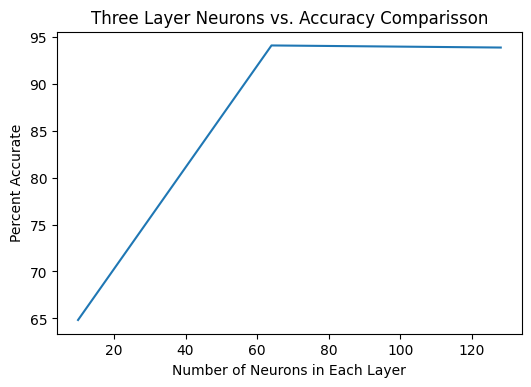

In [39]:
# We now plot our results to visualize our accuracy scores better
plt.plot([10, 64, 128], three_layer_scores)
plt.title("Three Layer Neurons vs. Accuracy Comparisson")
plt.xlabel("Number of Neurons in Each Layer")
plt.ylabel("Percent Accurate")
plt.show()

In [40]:
three_layer_scores

[64.82924563359346, 94.10237829803046, 93.87959866220737]

As expected, our model's performance declined when we incorporated 6-fold cross validation (as there are fewer elements to train on). We also can see that our network caps out around 64 neurons in terms of improvement. As a result, we should probably keep a three-layer, 64 neurons in each network model for optimal performance.

## Conclusion

In this project, we performed were able to implement an image classifier Neural Network model to help classify handwritten images from our data set. While this is somewhat of a "beginner friendly" model to incorporate, it showcases my ever-expan